# Primena **hijerarhijskog sakupljajućeg klasterovanja** nad podacima o aerodromima na osnovu njihove geografske lokacije i povezanosti letovima

  Ovde će povezanost imati isti uticaj kao i pri primeni algoritma **DBSCAN**. Primenjivaćemo iste dve metrike koje su detaljnije objašnjene u *notebook* - u za algoritam **DBSCAN**.
  
  Primenjivaćemo max - vezu, *Ward* - ovo rastojanje i prosečno rastojanje. Iz razloga objašnjenog u *notebook* - u u kome smo hijerarhijski klasterovali samo na osnovu lokacije i konstruisanog dendograma nećemo pokušavati sa primenom min - veze -- i ovde će    minimalna rastojanja biti već veoma bliska, zbog smanjivanja rastojanja sa uzimanjem postojanja veze između dva aerodroma ona mogu biti samo još manja (i time još bliskija).

## Neophodni importi

In [2]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import math
from mpl_toolkits.basemap import Basemap

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

## Učitavanje i kratak uvid u podatke

In [5]:
df = pd.read_csv("airportsSubtitleTools.com.csv") # podaci o aerodromima

whole_set = len(df) 
# print(whole_set)
df.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source,Altitude_CATEGORY,Coord_X,Coord_Y,Coord_X_Nearest_End
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports,2,16158.656679,-675.910224,3840.837979
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16202.779039,-578.707337,3796.715620
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports,2,16036.849596,-647.581008,3962.645063
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16306.913146,-730.158416,3692.581512
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16361.818285,-1049.523652,3637.676374


In [4]:
matrix_of_connections = pd.read_csv("../DataMining_FirstProject/Data/Matrica_povezanosti.csv")

matrix_of_connections.head(n = 10) # matrica povezanosti

,Source airport ID,1,2,3,4,5,6,7,8,9,...,5807,5809,5810,5832,5857,5858,5859,5875,5878,5885
0,1,0,8,12,6,16,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,8,0,24,12,16,56,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,12,24,0,18,48,84,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,6,12,18,0,24,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,16,16,48,24,0,28,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6,0,56,84,0,28,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,897,414,...,0,0,0,0,0,0,0,0,0,0
7,8,0,0,0,0,0,0,897,0,702,...,0,0,0,0,0,0,0,0,0,0
8,9,0,0,0,0,0,0,414,702,0,...,0,0,0,0,0,0,0,0,0,0
9,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Vizuelizacija

In [5]:
from mpl_toolkits.basemap import Basemap

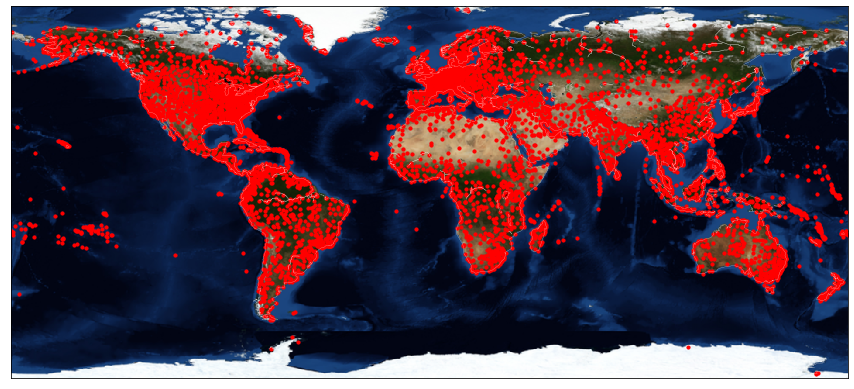

In [6]:
# make up some data for scatter plot
lats = np.random.randint(-75, 75, size=20)
lons = np.random.randint(-179, 179, size=20)

fig = plt.gcf()
fig.set_size_inches(15, 10)

m = Basemap(projection='cyl', \
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

x, y = m(list(df['Longitude']),list(df['Latitude']))  # transform coordinates


plt.scatter(x, y, 10, marker='o', color='Red') 

plt.show()

### Komponente povezanosti na osnovu letova

<img src = "components_of_connection.png" width = 600 />

## Preprocesiranje podataka

In [30]:
features = df.columns[6:8]
df[features].head()

scaler = MinMaxScaler()
scaler.fit(df[features])  
x = pd.DataFrame(scaler.transform(df[features])) 
x.columns = features
x['Airport ID'] = df['Airport ID']
x.head()

,Latitude,Longitude,Airport ID
0,0.486433,0.903957,1
1,0.491502,0.905060,2
2,0.487910,0.900911,3
3,0.483603,0.907664,4
4,0.466947,0.909037,5


## Pomoćne funkcije i metrike

In [11]:
# Suma reda
def sum_of_serie(d,n):
    s = 0
    
    if n >= 7: #Optimizacija: Nema svrhe da za veliki stepen idemo dalje
        ns = 7  
    else:
        ns = n
        
    member = 1
    for i in range(1,ns+1): 
        member /= d 
        s += member
    
    return s

# Euklidsko rastojanje
def euclidean__distance(a,b):
    
    return math.sqrt( ((a[0] - b[0])**2) + ((a[1] - b[1])**2) )

In [10]:
def metric_based_of_connection(a, b):
    
    id_a = int(a[2])
    id_b = int(b[2])

    matrix_columns = matrix_of_connections.columns
    matrix_rows = list(matrix_of_connections[' Source airport ID'])
    num_of_flights = 0
    
    if str(id_a) in matrix_columns and id_b in matrix_rows:
       # if len(list(matrix_of_connections.loc[
      #      matrix_of_connections[' Source airport ID'] == id_b][str(id_a)])) == 1:
            num_of_flights += list(matrix_of_connections.loc[
            matrix_of_connections[' Source airport ID'] == id_b][str(id_a)])[0]
        
    if str(id_b) in matrix_columns and id_a in matrix_rows:
      #  if len(list(matrix_of_connections.loc[
       #     matrix_of_connections[' Source airport ID'] == id_a][str(id_b)])) == 1:
            num_of_flights += list(matrix_of_connections.loc[
            matrix_of_connections[' Source airport ID'] == id_a][str(id_b)])[0]
    
    
    e = euclidean__distance(a,b)
    if num_of_flights == 0:
        return e
    sum_closer = sum_of_serie(4,num_of_flights)
    
    return e * (1.0 - sum_closer)

In [11]:
def light_metric(a,b): #Prvi koraci su identicni kao u prethodnom racunanju;
     #Izdvajamo karakteristike, citamo iz matrice povezanosti, racunamo euklidsko rastojanje
    id_a = int(a[2])
    id_b = int(b[2])
    matrix_columns = matrix_of_connections.columns
    matrix_rows = list(matrix_of_connections[' Source airport ID'])
    num_of_flights = 0
    if str(id_a) in matrix_columns and id_b in matrix_rows:
       # if len(list(matrix_of_connections.loc[
      #      matrix_of_connections[' Source airport ID'] == id_b][str(id_a)])) == 1:
            num_of_flights += list(matrix_of_connections.loc[
            matrix_of_connections[' Source airport ID'] == id_b][str(id_a)])[0]
    if str(id_b) in matrix_columns and id_a in matrix_rows:
      #  if len(list(matrix_of_connections.loc[
       #     matrix_of_connections[' Source airport ID'] == id_a][str(id_b)])) == 1:
            num_of_flights += list(matrix_of_connections.loc[
            matrix_of_connections[' Source airport ID'] == id_a][str(id_b)])[0]
    e = euclidean__distance(a,b)
    
    k = 7.5
    d = 20
    
    if num_of_flights > k:
        return (e * (1 - k/d))
    else:
        return (e * (1 - num_of_flights/d))

In [13]:
# Funkcija za opisivanje klastera
def describe_clusters(df, features ,n): # n - broj klastera
    if 'labels' not in df.columns:
        print("Ne postoji kolona sa klasterima ili se drugacije naziva")
        return
    print(" ~ Opis dobijenih klastera: ~\n\n\n")
    
    for i in range(1,n+1):
        this_cluster = df.loc[ df['labels'] == i]
        num_of_members = len(this_cluster)
        if num_of_members == 0: # Ako se dogodi da imamo prazan klaster
            continue              # Nema potrebe ispisivati informacije o njemu
        print("********** Klaster {} : **********\n\n\n".format(i))
        print("Udeo: {} % ".format( int((num_of_members/whole_set) * 100) ) )
        print(" - Deskriptivne statistike: ")
        print(this_cluster.describe()[features])
        print("\n\n\n\n\n")

In [12]:

# Omotač funkcija za klasterovanje i vizuelizaciju 
# Koristi već formiranu matricu veze, pa ćemo je koristiti za sve tipove veza
def model_agglomerative(z,x,df,t):
    df['labels'] = fcluster(z, t = t, criterion = 'distance')

    print("Dobijeni senka " + str(silhouette_score(x,df['labels'])))
    n = max(df['labels']) + 1
    
    describe_clusters(df = df,features = features,n = n)
    
    plt.figure(figsize= (20,10))
    for i in range(1,n):
        cluster = df[df['labels'] == i]
        plt.scatter(cluster['Longitude'], cluster['Latitude'], color = colors[i], label = "cluster %d"%i)

    plt.legend(loc = 2, prop = {'size' : 10})
    plt.show()

In [36]:
# Boje za vizuelizaciju klastera
colors = ['red','deepskyblue','gold','lightgreen','palevioletred','purple','orangered',
          'blueviolet','darkblue','cadetblue','indigo','tomato','mediumaquamarine',
          'olive','c','maroon','darkseagreen','cornflowerblue','orchid','lightcoral',
          'lavender','slateblue','yellowgreen','forestgreen','antiquewhite', 'sienna',
          'darkcyan','deeppink','thistle','plum','powderblue','sandybrown','m',
          'chartreuse','lemonchiffon','mistyrose','darkmagenta','brown','peru',
          'chocolate','royalblue']

## Primena algoritma - konstruisanje matrice rastojanja i dendograma, zatim klasterovanje sa odabranim parametrima na osnovu dendograma

Počećemo od max (*complete*) - veze.

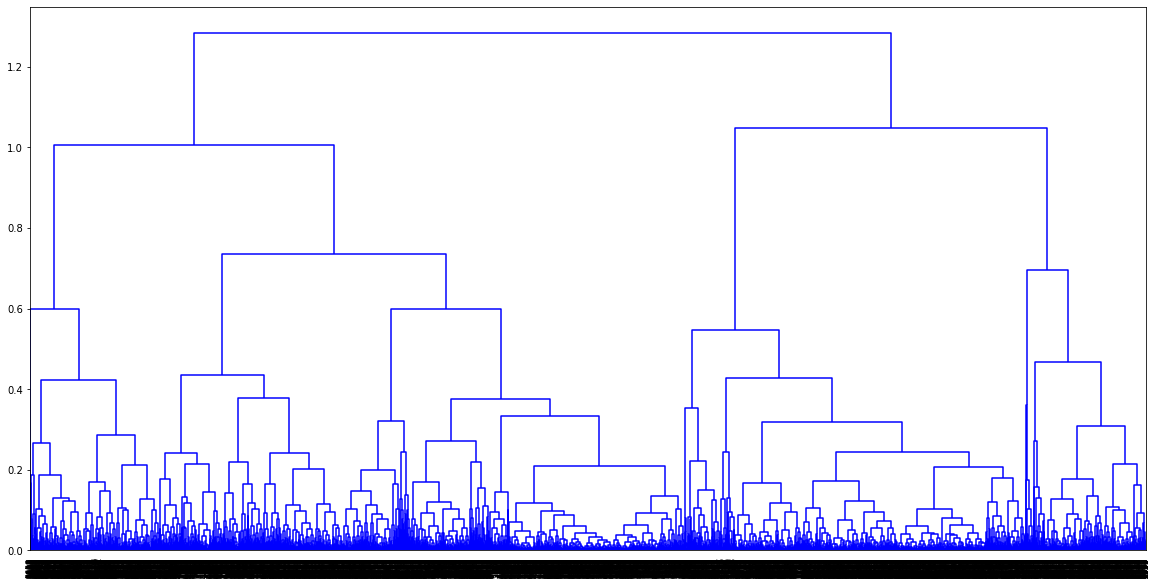

In [34]:
z = linkage(x,'complete', metric = metric_based_of_connection)

plt.figure(figsize=(20,10))
den = dendrogram(z, labels = x.index ,
                 distance_sort= True,leaf_font_size = 8, color_threshold= 0)

Dobijeni senka -0.12003770930519574


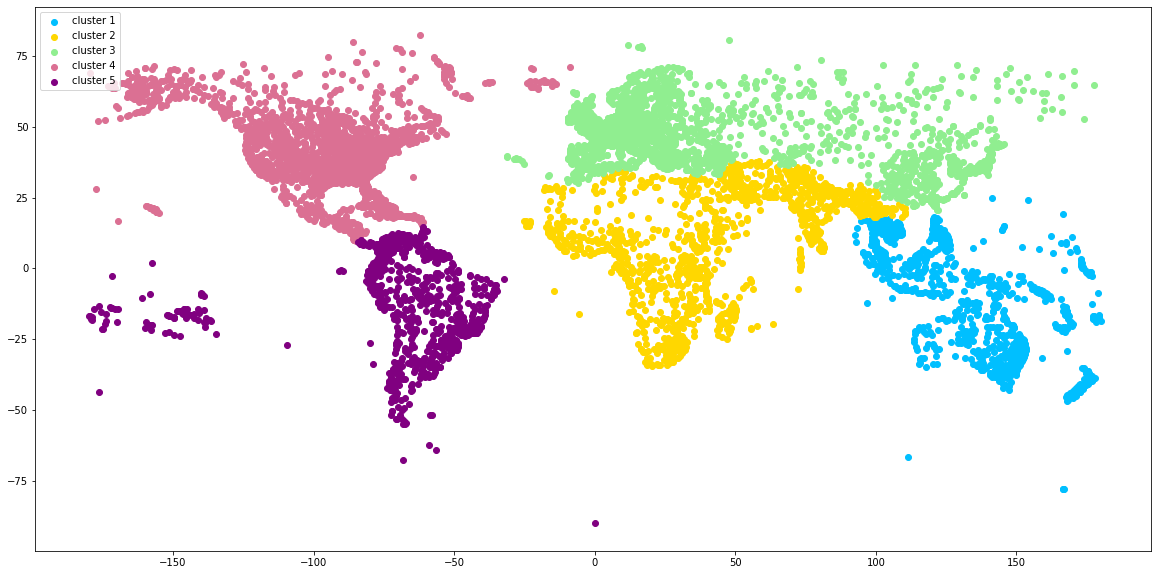

In [49]:

model_agglomerative(z=z,x=x,df=df,t=0.72)

Dobijeni senka -0.16670384192610038


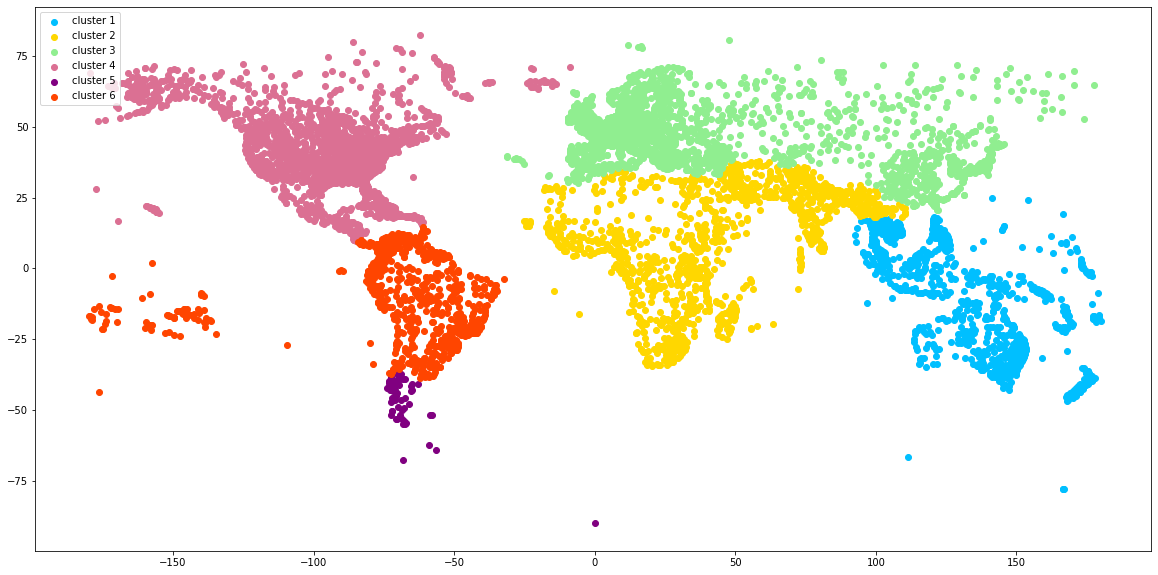

In [50]:
# I da vidimo kakav rezultat dobijamo za manji prag t
model_agglomerative(z=z,x=x,df=df,t=0.65)

Dobijeni senka -0.23517653684412165


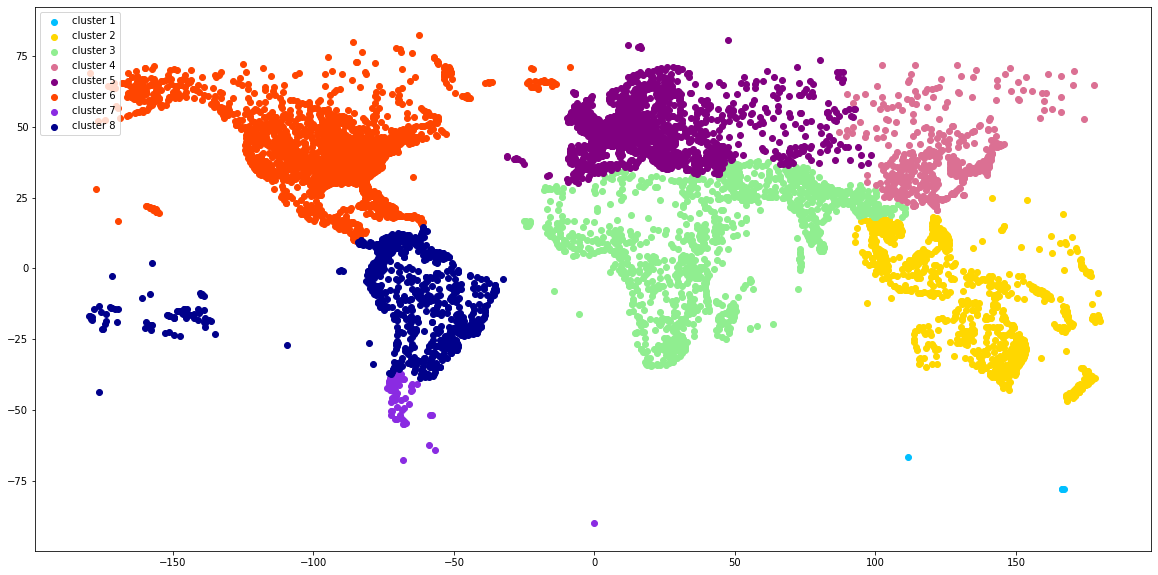

In [44]:
# Dalje pokušavamo, sad za veće vrednosti praga
model_agglomerative(z=z,df=df,x=x,t=0.55)

Dobijeni senka -0.5632283218122407


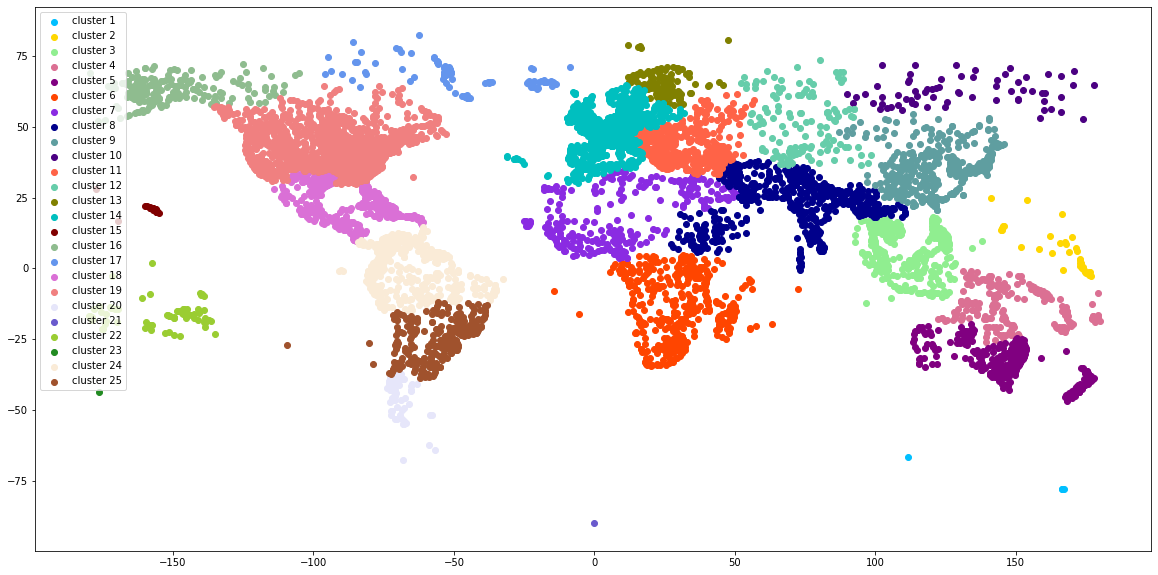

In [51]:
# Još povećavamo vrednost t
model_agglomerative(z=z,df=df,x=x,t=0.25)

Dobijeni senka 0.03446347404224178


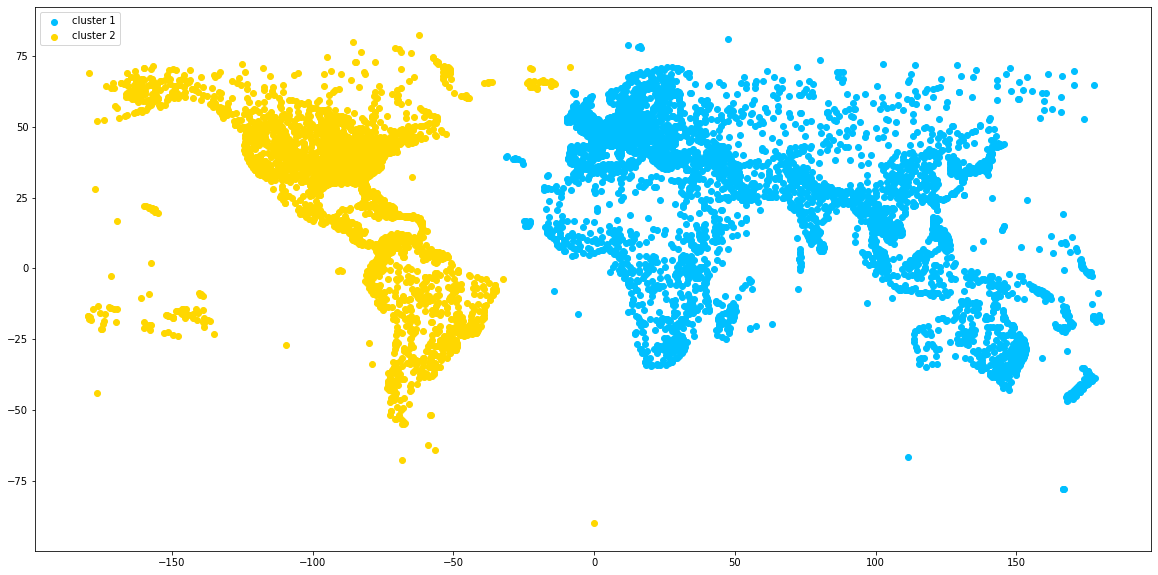

In [47]:
# Na kraju radi demonstracije, pusticemo za najvecu vrednost t = 1.2.
model_agglomerative(z=z,df=df,x=x,t=1.2)

Sada ćemo klasterovati na osnovu **prosečnog** rastojanja između elemenata iz različitih klastera.

In [ ]:
z = linkage(x,'average', metric = metric_based_of_connection)

plt.figure(figsize= (20,10) )
den = dendrogram(z,labels = x.index, color_threshold=0, distance_sort= True, leaf_font_size= 4)

In [ ]:
# Počećemo od manje vrednosti praga 
model_agglomerative(df=df,x=x,z=z,t=0.2)

In [ ]:
# Mnogo malih klastera u okviru velikih, međusobno isprepletani
model_agglomerative(df=df,x=x,z=z,t=0.22)

In [ ]:
model_agglomerative(df=df,x=x,z=z,t=0.3)

Za kraj pokušavamo i sa kriterijumom **Ward** - ove mere.

In [ ]:
z = linkage(x,method = "ward", metric = metric_based_of_connection)

plt.figure(figsize = (20,10))
den = dendrogram(z, labels = x.index,
                 color_threshold= 0 , distance_sort= True, leaf_font_size= 3)

In [ ]:
model_agglomerative(df=df,x=x,z=z,t= 5)

In [ ]:
model_agglomerative(df=df,x=x,z=z,t= 5.3)

#### Sad ponavljamo ceo isti postupak za drugu metriku

 -- Počećemo od max (*complete*) - veze.

In [ ]:
z = linkage(x,'complete', metric = light_metric)

plt.figure(figsize=(20,10))
den = dendrogram(z, labels = x.index ,
                 distance_sort= True,leaf_font_size = 8, color_threshold= 0)

In [ ]:
# Na osnovu dendograma, prvo 0.6 nam se čini kao najbolja opcija
model_agglomerative(z=z,x=x,df=df,t=0.6)

In [ ]:
# I da vidimo kakav rezultat dobijamo za manji prag t
model_agglomerative(z=z,x=x,df=df,t=0.44)

In [ ]:
# Dalje pokušavamo, sad za veće vrednosti praga
model_agglomerative(z=z,df=df,x=x,t=0.64)

In [ ]:
# Još povećavamo vrednost t
model_agglomerative(z=z,df=df,x=x,t=0.75)

In [ ]:
# Na kraju radi demonstracije, pusticemo za najvecu vrednost t = 1.2.
model_agglomerative(z=z,df=df,x=x,t=1.2)

Sada ćemo klasterovati na osnovu **prosečnog** rastojanja između elemenata iz različitih klastera.

In [ ]:
z = linkage(x,'average', metric = light_metric)

plt.figure(figsize= (20,10) )
den = dendrogram(z,labels = x.index, color_threshold=0, distance_sort= True, leaf_font_size= 4)

In [ ]:
# Počećemo od manje vrednosti praga 
model_agglomerative(df=df,x=x,z=z,t=0.2)

In [ ]:
# Mnogo malih klastera u okviru velikih, međusobno isprepletani
model_agglomerative(df=df,x=x,z=z,t=0.22)

In [ ]:
model_agglomerative(df=df,x=x,z=z,t=0.3)

Za kraj pokušavamo i sa kriterijumom **Ward** - ove mere.

In [ ]:
z = linkage(x,method = "ward", metric = light_metric)

plt.figure(figsize = (20,10))
den = dendrogram(z, labels = x.index,
                 color_threshold= 0 , distance_sort= True, leaf_font_size= 3)

In [ ]:
model_agglomerative(df=df,x=x,z=z,t= 5)

In [ ]:
model_agglomerative(df=df,x=x,z=z,t= 5.3)